In [1]:
# Import librairies needed for this project
import warnings
warnings.filterwarnings("ignore")

from authentification_token import string_connection
from sqlalchemy import create_engine
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter


import gc

import nltk
nltk.download("stopwords")
from nlp_utils_autism import remove_stopwords, normalize_corpus, plot_top_words
import sklearn
from sklearn.feature_extraction.text import  TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

import mlflow

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
sklearn.set_config(display="diagram")

## Cleaning

After running ETL script to collect data, we can connect to our database in order to obtain data.

In [3]:
STRING_CONNECTION = string_connection
engine = create_engine(STRING_CONNECTION)

In [4]:
df = pd.read_sql("reddit_extraction", 
                 con=engine)
df.drop("url", axis = 1, inplace=True)
df.head()

,index,title,score,id,num_comments,text,subreddit_name
0,2,"Dear *those* autistic men,",345,13h5ymk,123,Our lives aren't automatically better then you...,Autism
1,3,You only accept it as long as it doesn’t incon...,1085,13gyesp,48,None,Autism
2,4,Yeah basically.,434,13gxkud,8,None,Autism
3,5,"""i feel like neurotypical people actually enjo...",807,13gsoty,37,None,Autism
4,6,"Or, if I have different colors, I have to eat ...",425,13gxlkt,16,None,Autism


In [5]:
df.drop_duplicates('id', inplace=True)

In [6]:
df.dropna(inplace=True, how="any")
df.shape

(6252, 7)

The data are almost clean. We just need to remove the URL (we don't use it for our analysis) and take care that we have no duplicated data. In order to remove them, we can use the id column. Each post is identified by an unique id. Finally, we remove the nan values in the text column.

## Data Analysis

First, an analysis on the quantitative data is realised. Only two variables are concerned:
- the score
- the number of comments.
Later, these values can be used in order to remove some outliers. For the moment, every post is kept.

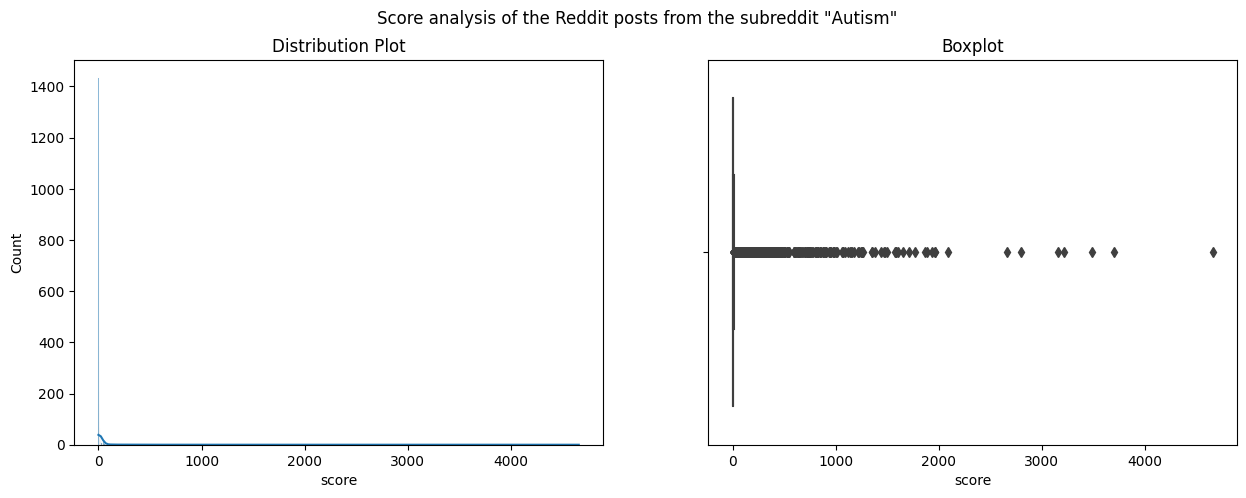

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score analysis of the Reddit posts from the subreddit "Autism"')

sns.histplot(ax=axes[0], x="score", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [8]:
print("Mean score:", (np.mean(df["score"])).round(2))
print("Median score:", np.median(df["score"]))

Mean score: 34.04
Median score: 2.0


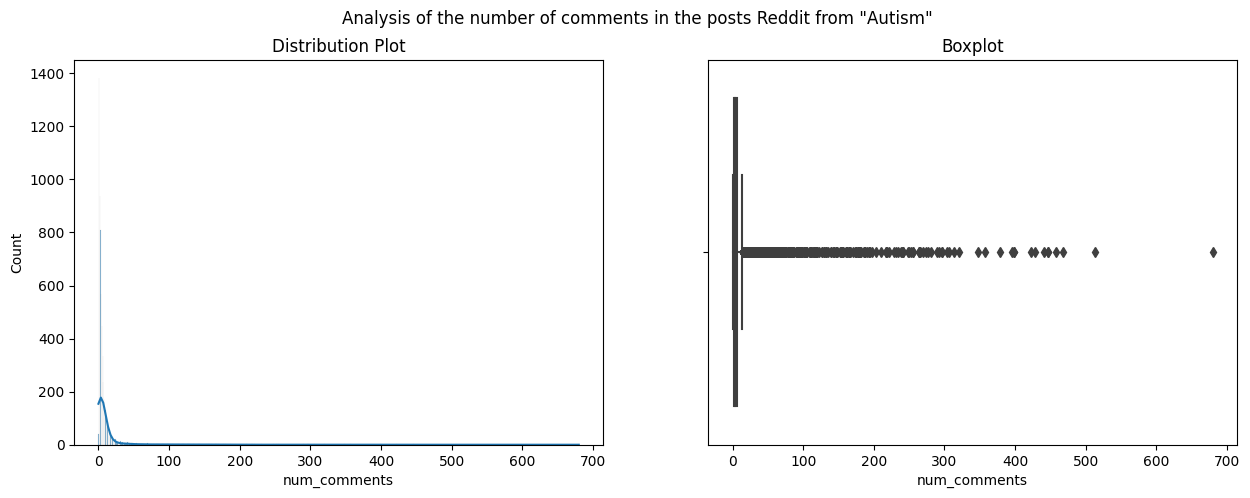

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Analysis of the number of comments in the posts Reddit from "Autism"')

sns.histplot(ax=axes[0], x="num_comments", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [10]:
print("Mean number of comments: ", (np.mean(df["num_comments"]).round(2)))
print("Median number of comments: ", np.median(df["num_comments"]))

Mean number of comments:  11.28
Median number of comments:  3.0


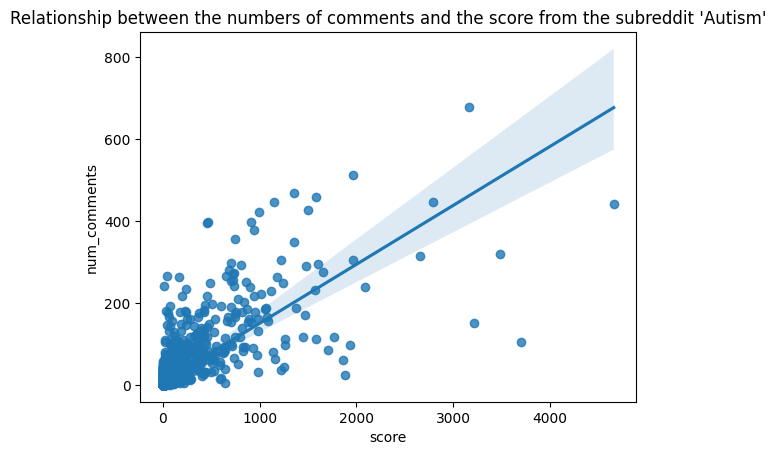

In [11]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between the numbers of comments and the score from the subreddit 'Autism'")
plt.show()

Now, the text analysis begin. It is separated in two parts : 
- one part about the title
- one part about the text (when it exists)

## Title Analysis

In [12]:
df_title = df[["id","title"]]
df_title.head()

,id,title
0,13h5ymk,"Dear *those* autistic men,"
6,13h6s7n,I am a server. I waited on someone with autism...
7,13h3c1h,"The Love of my life, while on the spectrum…"
9,13h3wzn,DJing has been a great way for me to share one...
10,13gpg1j,It makes me extremely angry that we don’t have...


In [13]:
df_title["title_norm"] = normalize_corpus(df_title["title"])
df_title.head()

,id,title,title_norm
0,13h5ymk,"Dear *those* autistic men,",dear man
6,13h6s7n,I am a server. I waited on someone with autism...,I server I wait stop
7,13h3c1h,"The Love of my life, while on the spectrum…",love life
9,13h3wzn,DJing has been a great way for me to share one...,djing great I share special interest stim freely
10,13gpg1j,It makes me extremely angry that we don’t have...,I extremely angry male sa statistic


In [14]:
vectorizer_tf = TfidfVectorizer()

tfidf_title = vectorizer_tf.fit_transform(df_title['title_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.mean(), columns=["Value"])
df_title_tf = df_title_tf.sort_values("Value",ascending=False)
df_title_tf = df_title_tf.head(30)
df_title_tf = df_title_tf.sort_values("Value", ascending=True)

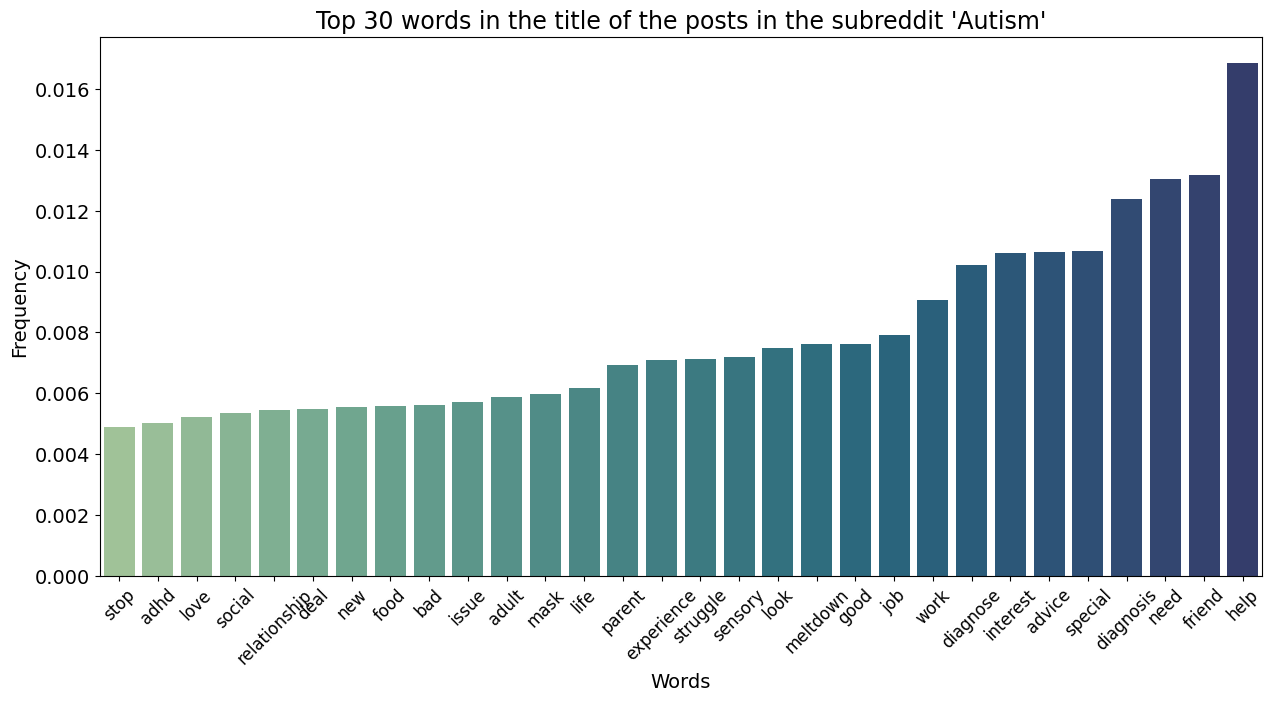

In [15]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_title_tf.index,
    y = df_title_tf["Value"],
    data = df_title_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the title of the posts in the subreddit 'Autism'", fontsize = 17)

plt.show()

In [16]:
df_title.to_csv("data/autism-title.csv")

In [17]:
del(df_title)
gc.collect()

516207

## Content Analysis

In [18]:
df_text = df[["id","text"]]

In [19]:
df_text["text_norm"] = normalize_corpus(df_text["text"])
df_text.head()

,id,text,text_norm
0,13h5ymk,Our lives aren't automatically better then you...,life automatically well stuggle girlfriend stu...
6,13h6s7n,I (20M) work at a popular soul food chain in t...,I work popular soul food chain southeast part ...
7,13h3c1h,"Ever since I was 11 years old, I’ve always wan...",ever since I year old I girlfriend yes ik youn...
9,13h3wzn,I have been DJing for about 5 years and am now...,I dj year gig I actually enjoy I share small v...
10,13gpg1j,9/10 Afab autistic people get SAed in their li...,afab saed lifetime I attempt amab statistic si...


In [20]:
vectorizer_tf = TfidfVectorizer()
tfidf_text = vectorizer_tf.fit_transform(df_text['text_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_text_tf = pd.DataFrame(tfidf_text, columns=feature_names)
df_text_tf = pd.DataFrame(df_text_tf.mean(), columns=["Value"])
df_text_tf = df_text_tf.sort_values("Value",ascending=False)
df_text_tf = df_text_tf.head(30)
df_text_tf = df_text_tf.sort_values("Value", ascending = True)

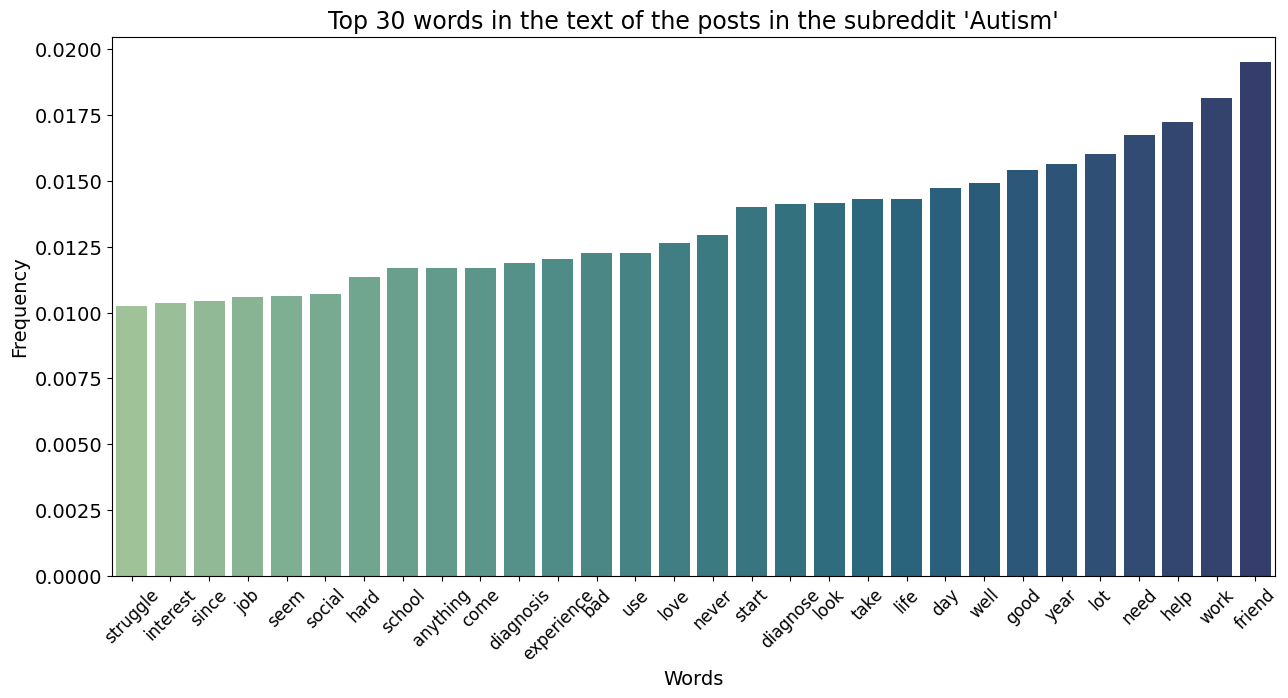

In [21]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_text_tf.index,
    y = df_text_tf["Value"],
    data = df_text_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the text of the posts in the subreddit 'Autism'", fontsize = 17)

plt.show()

In [22]:
df_text.to_csv("data/autism-text.csv")
del(df_text)
gc.collect()

9696

## Topic modeling

In [23]:
data_title = pd.read_csv("data/autism-title.csv")
data_text = pd.read_csv("data/autism-text.csv")

In [24]:
data_title.dropna(inplace=True, how = "any")
data_text.dropna(inplace=True, how="any")

In [25]:
docs = data_title["title_norm"] + " " + data_text["text_norm"]

In [26]:
docs = docs.values.astype('U')

In [27]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [28]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.252 %


### NMF

In [29]:
dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [30]:
topic_nums = list(np.arange(5, 10 + 1, 1))
coherence_scores = []

In [31]:
for num in topic_nums:
    nmf = Nmf(
        corpus = corpus,
        num_topics = num, 
        id2word=common_dictionary,
        chunksize = 2000,
        normalize = True,
        random_state = 42
    )

    cm = CoherenceModel(
        model = nmf,
        texts = dataset,
        dictionary=common_dictionary,
        coherence = 'c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

In [32]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

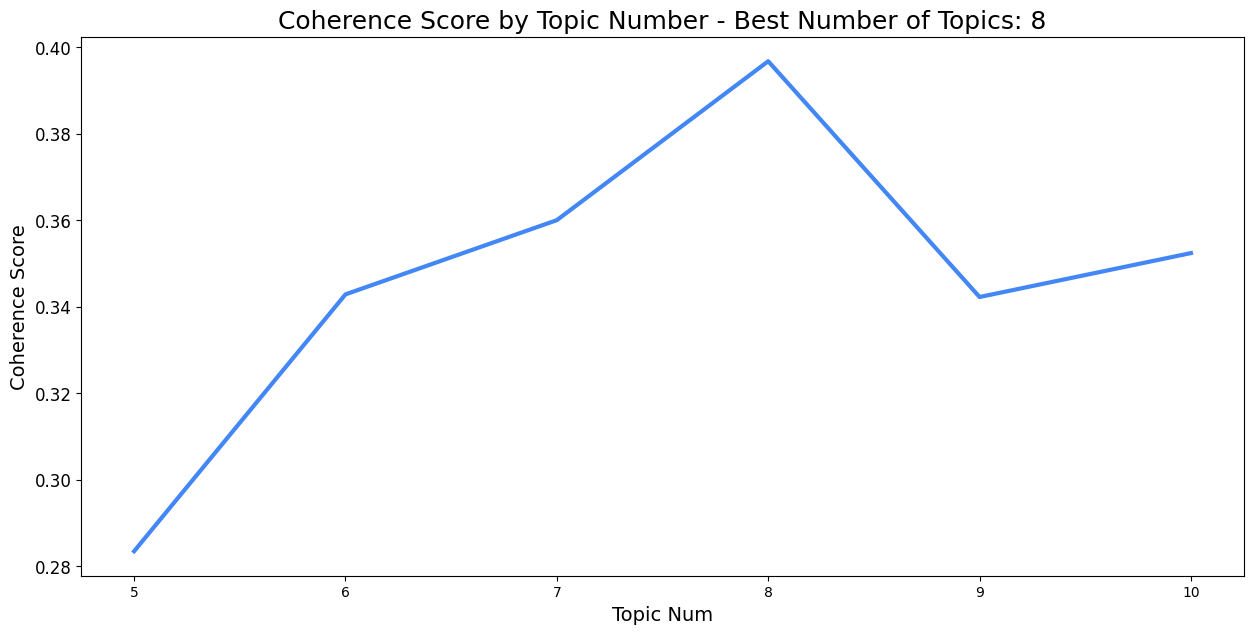

In [33]:
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.yticks(fontsize=12)

plt.show()

In [34]:
nmf = NMF(n_components = 8,
          random_state = 42)
nmf.fit(tfidf)

NMF(n_components=8, random_state=42)

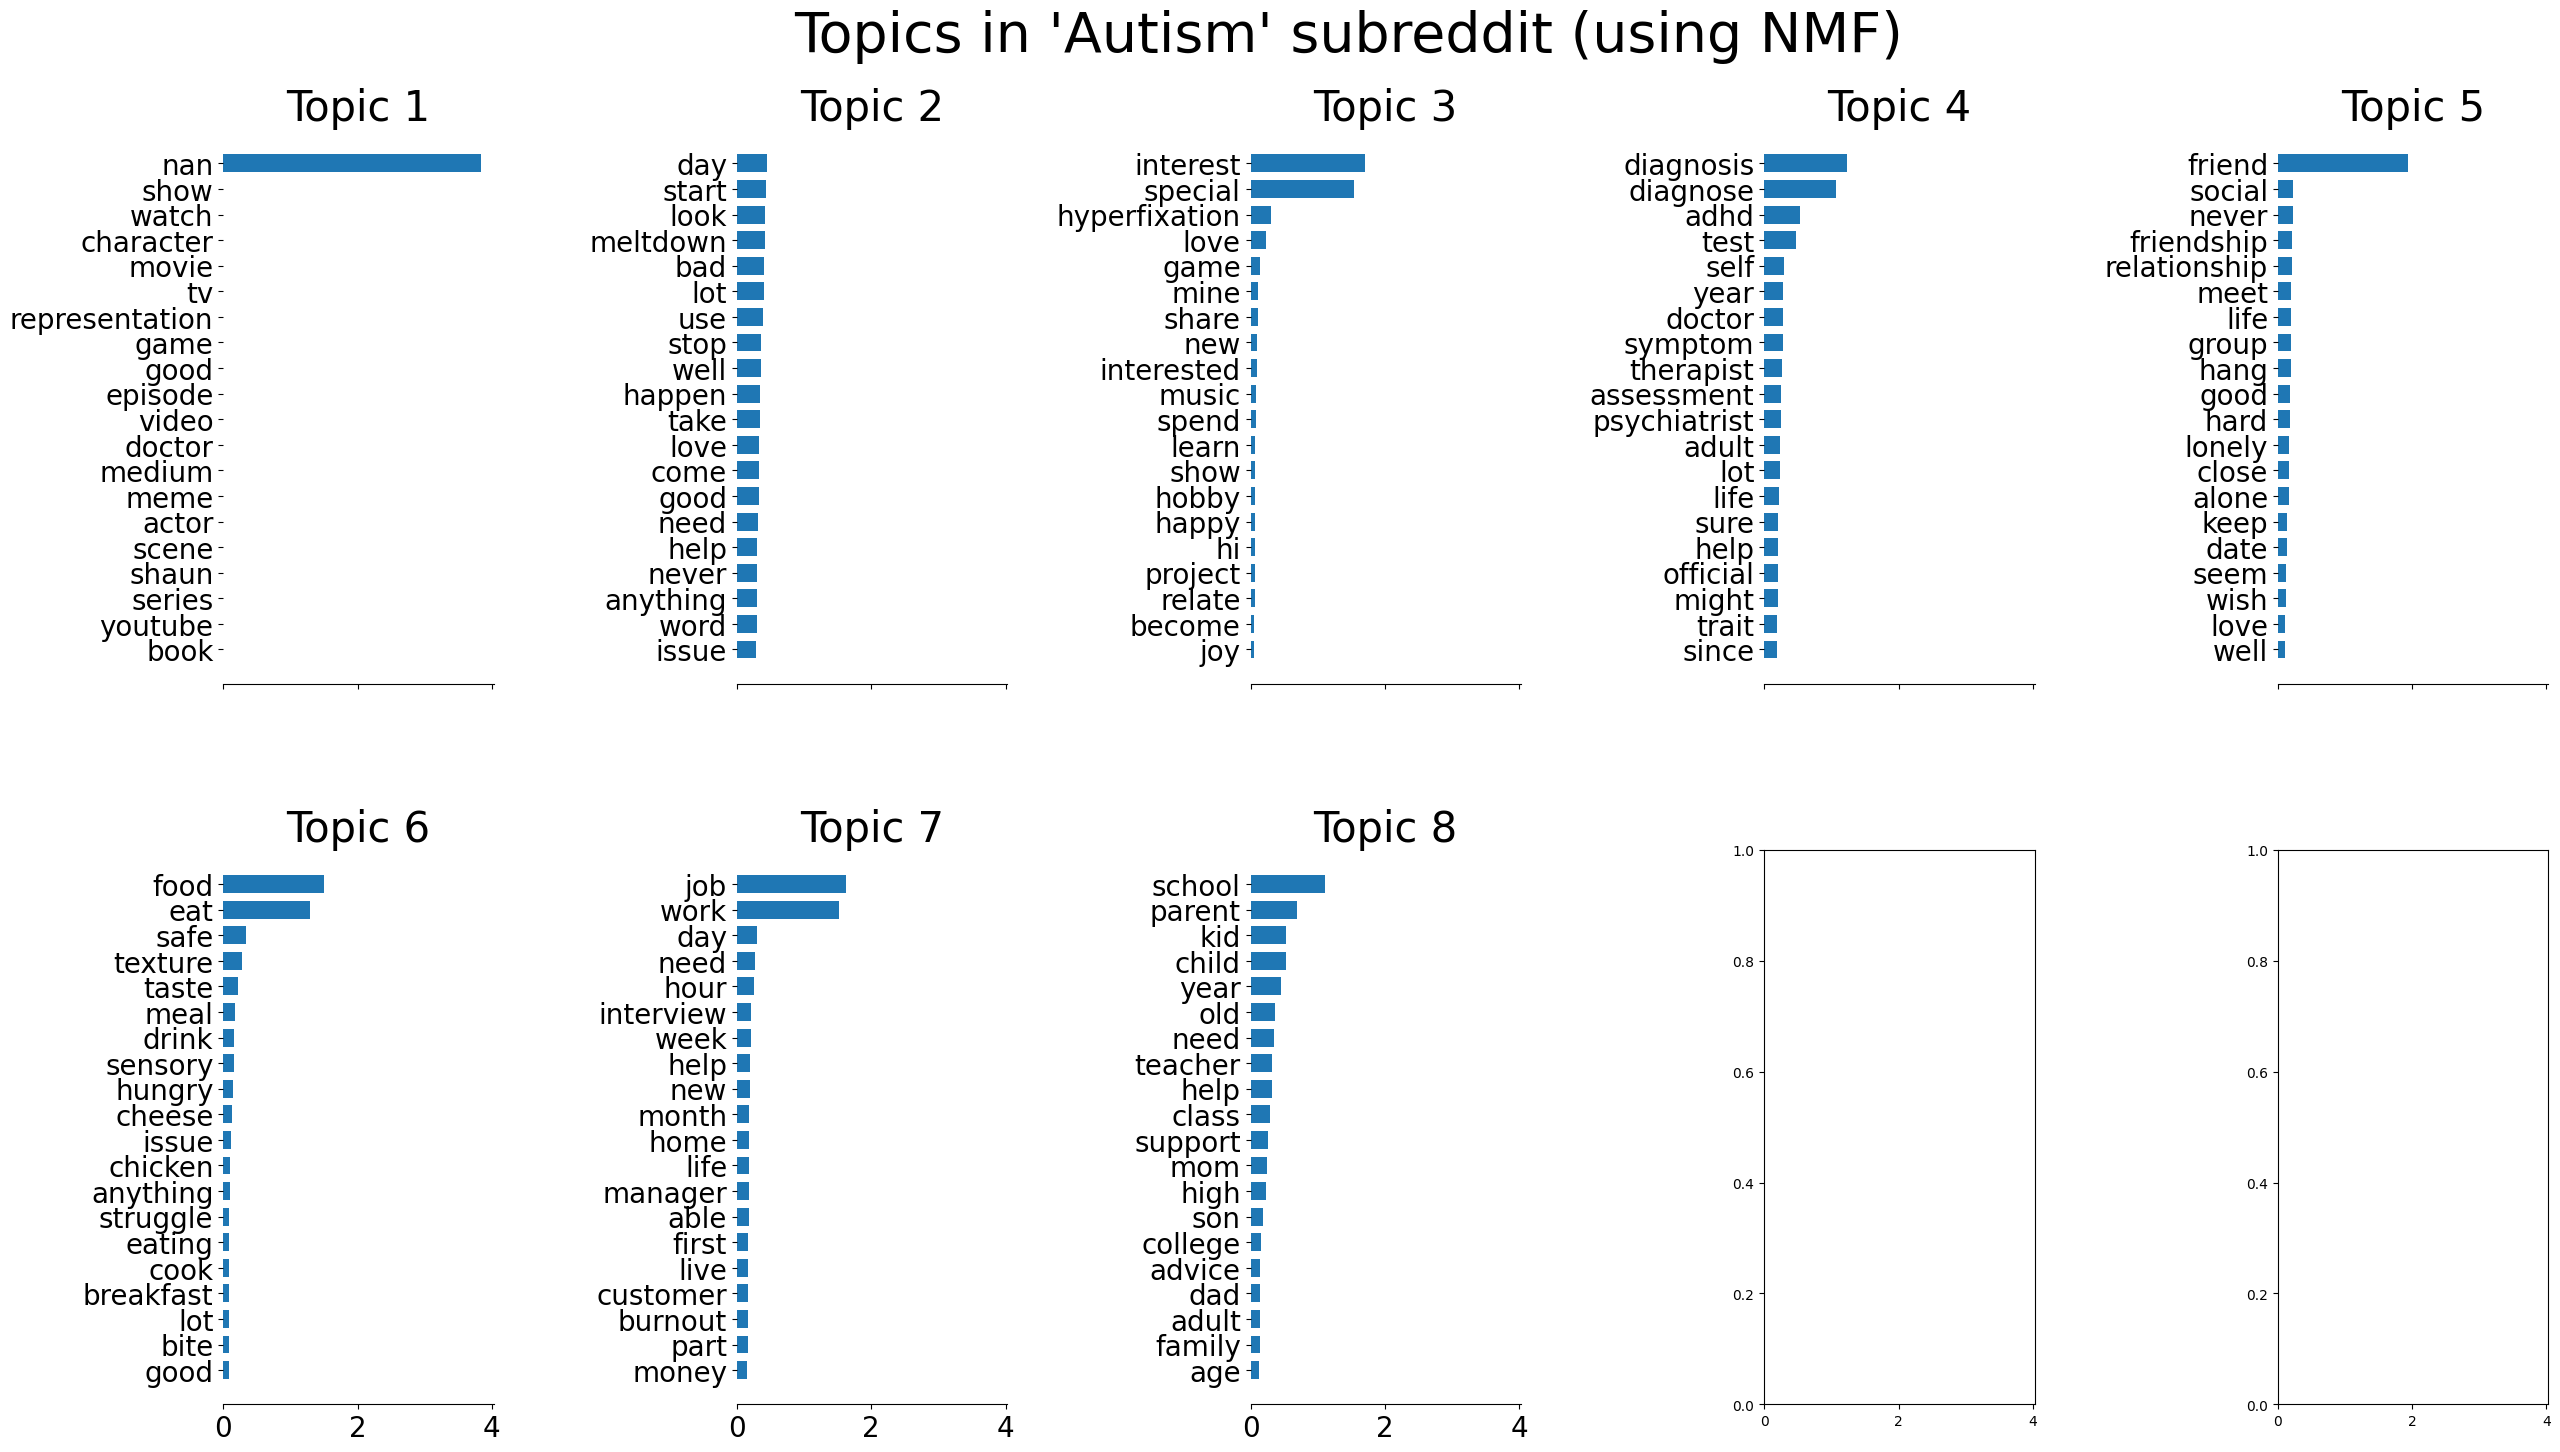

In [35]:
plot_top_words(nmf, 
               tfidf_feature_names, 
               n_top_words = 20, 
               title = "Topics in 'Autism' subreddit (using NMF)")

- Topic 1: Social Representation
- Topic 2: Daily life
- Topic 3: Special interests
- Topic 4: (mental) Health
- Topic 5: Relationship
- Topic 6: Food & Drink
- Topic 7: Work
- Topic 8: School & Parenthood

### Labelling data

After finding the 8 topics, we can assign them to each posts. In order to create a classification model.

In [36]:
df = pd.DataFrame()
df['id'] = data_title['id']
df["title"] = data_title["title"]
df["text"] = data_text["text"]
df["title_&_text_norm"] = data_title["title_norm"] + " " + data_text["text_norm"] 

In [37]:
df.head()

,id,title,text,title_&_text_norm
0,13h5ymk,"Dear *those* autistic men,",Our lives aren't automatically better then you...,dear man life automatically well stuggle girlf...
1,13h6s7n,I am a server. I waited on someone with autism...,I (20M) work at a popular soul food chain in t...,I server I wait stop I work popular soul food ...
2,13h3c1h,"The Love of my life, while on the spectrum…","Ever since I was 11 years old, I’ve always wan...",love life ever since I year old I girlfriend y...
3,13h3wzn,DJing has been a great way for me to share one...,I have been DJing for about 5 years and am now...,djing great I share special interest stim free...
4,13gpg1j,It makes me extremely angry that we don’t have...,9/10 Afab autistic people get SAed in their li...,I extremely angry male sa statistic afab saed ...


In [38]:
def topic_table(n_top_words, feature_names, nmf):
  topics = {}
  for i, topic_vec in enumerate(nmf.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

In [39]:
topic_df = topic_table(5, tfidf_vectorizer.get_feature_names_out(), nmf)

topic_df['Label'] = ['Social Representation', 'Daily life', 
                     'Special Interests', 'Health', 
                     'Relationship', 'Food & Drink',
                     'Work', 'School & Parenthood']

document_weights = nmf.transform(tfidf_vectorizer.transform(df['title_&_text_norm'].astype('U')))

df["Topic_Number"] = document_weights.argmax(axis=1)
df = pd.merge(df, 
              topic_df, 
              left_on='Topic_Number', 
              right_index=True, 
              how='left')

#### Supervised Learning

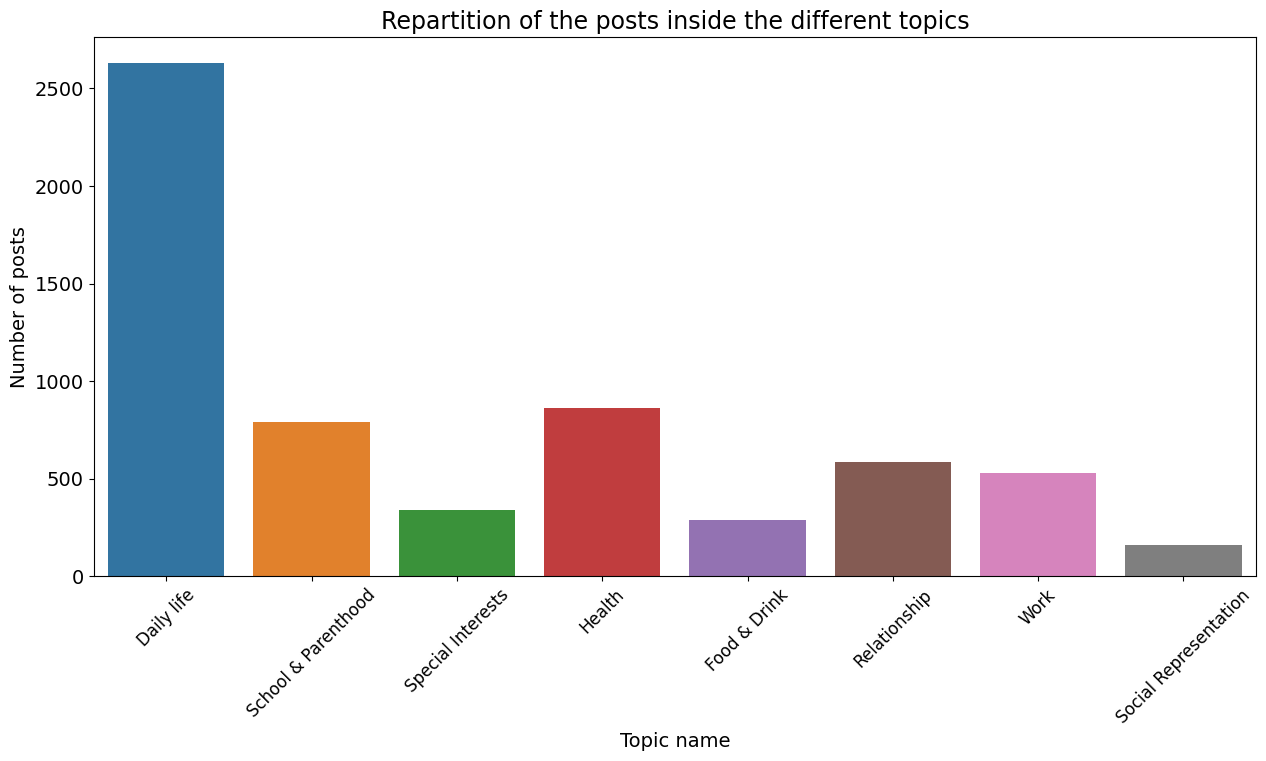

In [40]:
fig = plt.figure(figsize=(15, 7))

g = sns.countplot(x = "Label",
              data = df)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12)


plt.yticks(fontsize = 14)
plt.xlabel("Topic name", fontsize = 14)
plt.ylabel("Number of posts", fontsize = 14)
plt.title("Repartition of the posts inside the different topics", fontsize = 17)

plt.show()

Classification models

In [41]:
df.drop(["id", "title", "text", "Top_Topic_Terms"], 
        axis = 1,
        inplace=True)

In [42]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, 
                                     test_size=0.25, 
                                     random_state=42)

y_train = train_set[["Topic_Number"]]
y_test = test_set[["Topic_Number"]]
X_train = train_set.drop(["Label","Topic_Number"], axis = 1)
X_test = test_set.drop(["Label","Topic_Number"], axis = 1)

In [43]:
len(X_train), len(X_test)

(4640, 1547)

In [44]:
X_train.head()

,title_&_text_norm
5137,club I university september first year I look ...
204,male aspie sex amount I comment post subject w...
341,I yr old son use justify bullying I apologize ...
3823,put finger grow undiagnosed edition put finger...
840,especially good cat anecdotally I notice true ...


In [45]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train['title_&_text_norm'].astype('U'))
X_train_vec = tfidf.transform(X_train['title_&_text_norm'].astype('U'))
X_test_vec = tfidf.transform(X_test['title_&_text_norm'].astype('U'))

In [46]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("reddit-classifier")

2023/06/16 22:47:32 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/16 22:47:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/cecile/Documents/Reddit-Analysis/reddit-nlp-analysis/autism/mlruns/1', creation_time=1686948458540, experiment_id='1', last_update_time=1686948458540, lifecycle_stage='active', name='reddit-classifier', tags={}>

In [53]:
mlflow.sklearn.autolog()

with mlflow.start_run():
    mlflow.set_tag("developper", "cecile")
    n_estimators = 200
    mlflow.log_param("n_estimators", n_estimators)
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=42)
    rf.fit(X_train_vec, y_train)

    y_pred = rf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

2023/06/16 22:50:29 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'toarray'
2023/06/16 22:50:46 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: too many indices for array: array is 2-dimensional, but 3 were indexed


In [54]:
print("Accuracy Score: ", round(accuracy, 5) * 100, "%")

Accuracy Score:  83.387 %


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

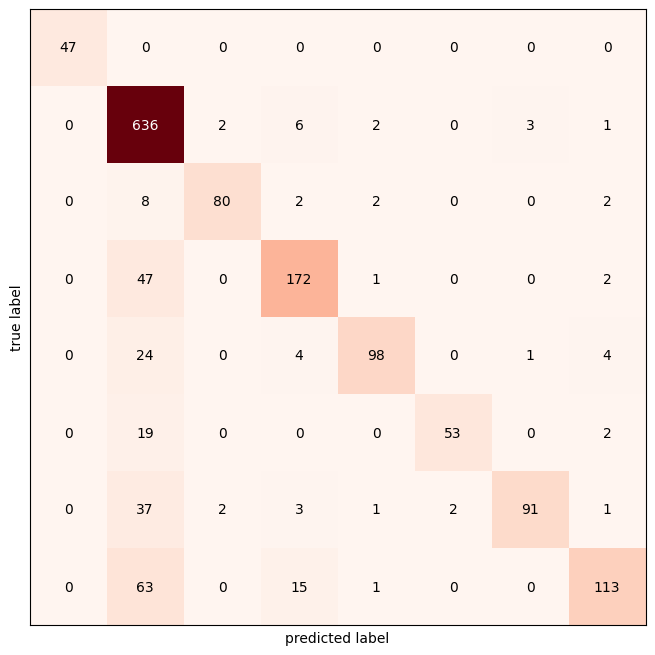

In [55]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize = (12,8), hide_ticks = True, cmap=plt.cm.Reds)